In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

class OralCancerDetector:
    def __init__(self, dataset_path, img_size=(224, 224), batch_size=64):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        
        # Set random seeds for reproducibility
        np.random.seed(42)
        tf.random.set_seed(42)
        
    def load_data(self):
        """Load and prepare the dataset"""
        filepath = []
        labels = []
        
        for category in ['oral_normal', 'oral_scc']:
            category_path = os.path.join(self.dataset_path, category)
            for image in os.listdir(category_path):
                filepath.append(os.path.join(category_path, image))
                labels.append(category)
                
        df = pd.DataFrame({'filepath': filepath, 'labels': labels})
        
        # Split data
        train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['labels'])
        valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'])
        
        return train_df, valid_df, test_df
    
    def create_data_generators(self, train_df, valid_df, test_df):
        """Create data generators for training, validation and testing"""
        datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        train_gen = datagen.flow_from_dataframe(
            train_df,
            x_col='filepath',
            y_col='labels',
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        
        valid_gen = test_datagen.flow_from_dataframe(
            valid_df,
            x_col='filepath',
            y_col='labels',
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )
        
        test_gen = test_datagen.flow_from_dataframe(
            test_df,
            x_col='filepath',
            y_col='labels',
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        return train_gen, valid_gen, test_gen
    
    def build_model(self, model_type='efficientnet'):
        """Build the model architecture"""
        if model_type == 'efficientnet':
            base_model = EfficientNetB0(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )
        else:
            base_model = ResNet50(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )
            
        for layer in base_model.layers:
            layer.trainable = False
            
        self.model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.25),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.25),
            Dense(2, activation='sigmoid')
        ])
        
        self.model.compile(
            optimizer=Adamax(learning_rate=0.002),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return self.model
    
    def train(self, train_gen, valid_gen, epochs=50, checkpoint_path='best_model.keras'):
        """Train the model"""
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
        ]
        
        self.history = self.model.fit(
            train_gen,
            epochs=epochs,
            validation_data=valid_gen,
            callbacks=callbacks
        )
        
        return self.history
    
    def evaluate(self, test_gen):
        """Evaluate the model and generate performance metrics"""
        # Load best model
        self.model = load_model('best_model.keras')
        
        # Get predictions
        y_pred_prob = self.model.predict(test_gen)
        y_pred_classes = np.argmax(y_pred_prob, axis=1)
        y_true = test_gen.classes
        
        # Calculate metrics
        test_loss, test_accuracy = self.model.evaluate(test_gen, verbose=0)
        
        return {
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'confusion_matrix': confusion_matrix(y_true, y_pred_classes),
            'classification_report': classification_report(y_true, y_pred_classes,
                                                        target_names=['Normal', 'SCC'])
        }
    
    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Loss plot
        ax1.plot(self.history.history['loss'], 'o-', label='Training Loss')
        ax1.plot(self.history.history['val_loss'], 's--', label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Accuracy plot
        ax2.plot(self.history.history['accuracy'], 'o-', label='Training Accuracy')
        ax2.plot(self.history.history['val_accuracy'], 's--', label='Validation Accuracy')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        return fig

Found 7001 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 1501 validated image filenames belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 99s 680ms/step - accuracy: 0.4963 - loss: 0.8056 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 272ms/step - accuracy: 0.4840 - loss: 0.7646 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 31s 269ms/step - accuracy: 0.5038 - loss: 0.7467 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 274ms/step - accuracy: 0.4975 - loss: 0.7381 - val_accuracy: 0.4973 - val_loss: 0.6951
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - accuracy: 0.5129 - loss: 0.7321 - val_accuracy: 0.5000 - val_loss: 0.6974
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 278ms/step - accuracy: 0.4931 - loss: 0.7267 - val_accuracy: 0.5000 - val_loss: 0.6941
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.5003

Classification Report:
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67       751
         SCC       0.00      0.00      0.00       750

    accuracy                           0.50      1501
   macro avg       0.25      0.50      0.33      1501
weighted avg       0.25      0.50      0.33      1501



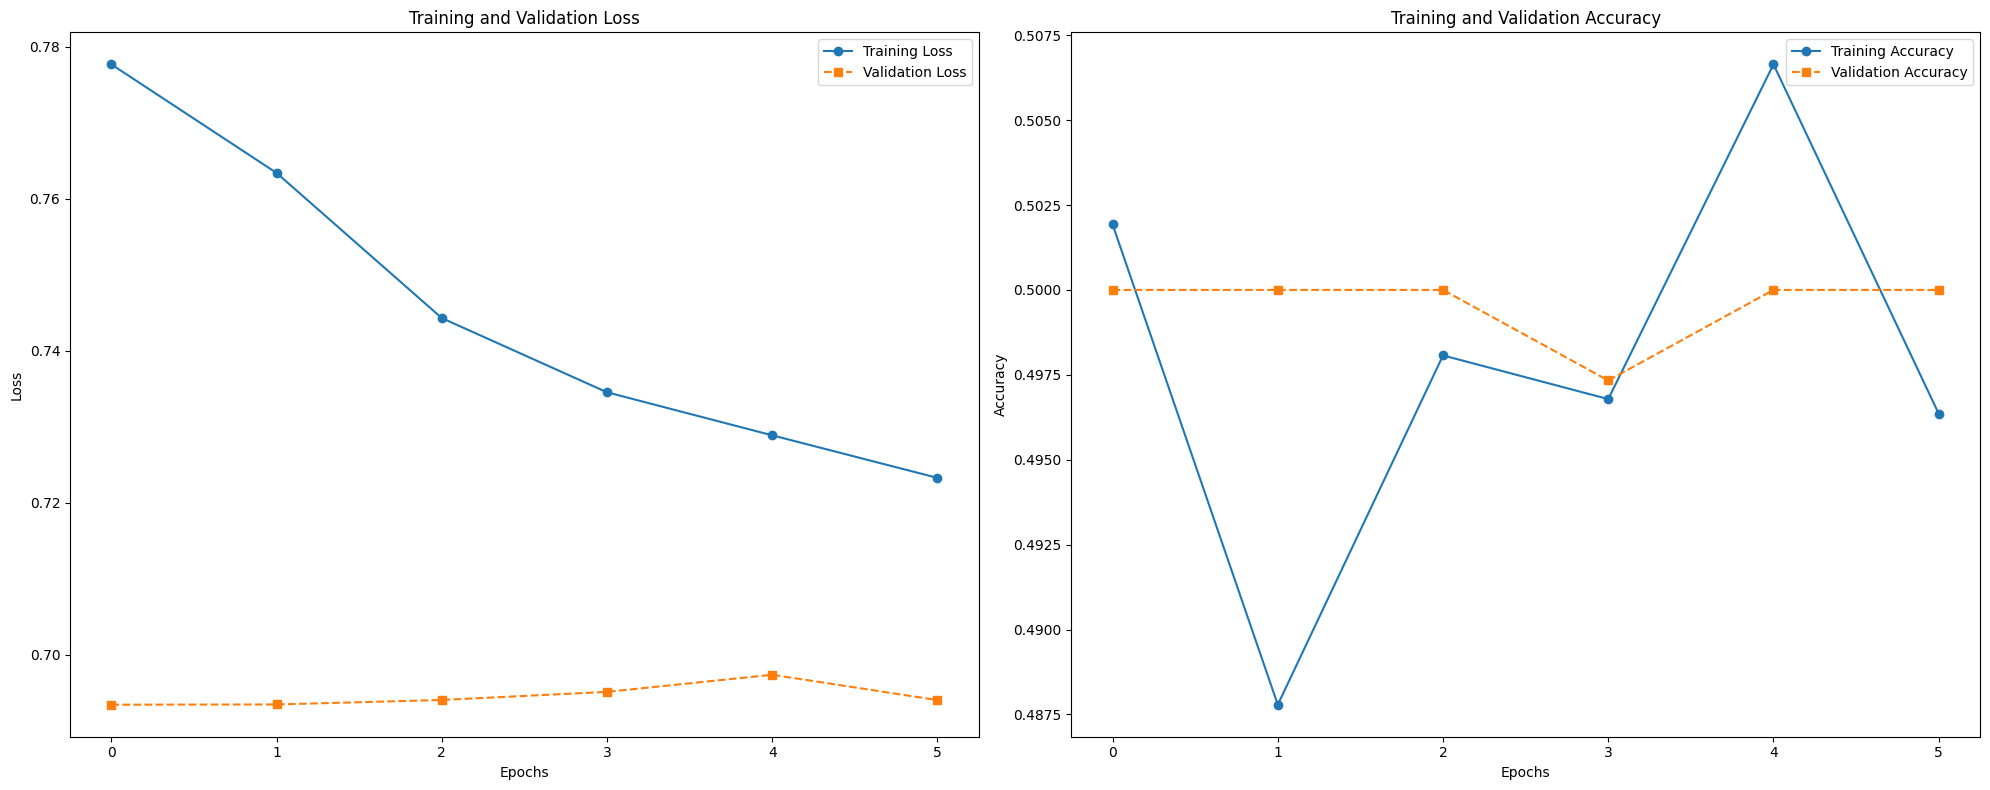

In [2]:
# Initialize the detector
detector = OralCancerDetector(dataset_path='/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer')

# Load and prepare data
train_df, valid_df, test_df = detector.load_data()
train_gen, valid_gen, test_gen = detector.create_data_generators(train_df, valid_df, test_df)

# Build and train model
model = detector.build_model(model_type='efficientnet')
history = detector.train(train_gen, valid_gen)

# Evaluate performance
metrics = detector.evaluate(test_gen)
print(f"Test Accuracy: {metrics['test_accuracy']:.4f}")
print("\nClassification Report:")
print(metrics['classification_report'])

# Plot training history
detector.plot_training_history()
plt.show()